# TF-IDF Example from scikit-learn docs

Adapted from:

https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

In [4]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
import logging
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


In [5]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [6]:
CPA = pd.read_csv("../data/processed/CPA_tokenized.csv")
CPA.drop('Unnamed: 0', axis=1, inplace=True)
CPA.head()

,Order,Level,Code,Parent,Descr,tokens
0,1208792,1,A,NaN,"PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING",PRODUCTS OF AGRICULTURE FORESTRY AND FISHING
1,1208793,2,01,A,"Products of agriculture, hunting and related s...",Products agriculture hunting related services
2,1208794,3,01.1,01,Non-perennial crops,Non-perennial crops
3,1208795,4,01.11,01.1,"Cereals , leguminous crops and oil seeds",Cereals leguminous crops oil seeds
4,1208796,5,01.11.1,01.11,Wheat,Wheat


In [7]:
# Create categories for Level 1 and Level 2 higherarchies
CPA2 = CPA.copy()
#get highest level of code
CPA2.loc[CPA2.Level !=1,'Category_2'] = CPA2[CPA2.Level !=1].Code.str.split('.').str.slice(0,1).str.join('')

# match up codes and parents
Code_parent = CPA2[CPA2.Level==2][['Parent','Category_2']].copy()
CPA2 = CPA2.merge(Code_parent.rename(columns={'Parent':'Category_1'}), on='Category_2', how='left')

# we now set up a higher level for A10 indstry levels (10 categories)
CPA2.loc[CPA2.Category_1.isin({'A'}), 'Category_0'] = 1
CPA2.loc[CPA2.Category_1.isin({'B','C','D','E'}), 'Category_0'] = 2
CPA2.loc[CPA2.Category_1.isin({'F'}), 'Category_0'] = 3
CPA2.loc[CPA2.Category_1.isin({'G','H','I'}), 'Category_0'] = 4
CPA2.loc[CPA2.Category_1.isin({'J'}), 'Category_0'] = 5
CPA2.loc[CPA2.Category_1.isin({'K'}), 'Category_0'] = 6
CPA2.loc[CPA2.Category_1.isin({'L'}), 'Category_0'] = 7
CPA2.loc[CPA2.Category_1.isin({'M','N'}), 'Category_0'] = 8
CPA2.loc[CPA2.Category_1.isin({'O','P','Q'}), 'Category_0'] = 9
CPA2.loc[CPA2.Category_1.isin({'R','S','T','U'}), 'Category_0'] = 10


CPA2[CPA2.Level==2]

2020-11-05 10:00:08,027 INFO NumExpr defaulting to 4 threads.


,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0
1,1208793,2,01,A,"Products of agriculture, hunting and related s...",Products agriculture hunting related services,01,A,1.0
274,1209066,2,02,A,"Products of forestry, logging and related serv...",Products forestry logging related services,02,A,1.0
307,1209099,2,03,A,Fish and other fishing products; aquaculture p...,Fish fishing products aquaculture products sup...,03,A,1.0
345,1209137,2,05,B,Coal and lignite,Coal lignite,05,B,2.0
354,1209146,2,06,B,Crude petroleum and natural gas,Crude petroleum natural gas,06,B,2.0
...,...,...,...,...,...,...,...,...,...
5433,1214225,2,95,S,Repair services of computers and personal and ...,Repair services computers personal household g...,95,S,10.0
5465,1214257,2,96,S,Other personal services,Other personal services,96,S,10.0
5498,1214290,2,97,T,Services of households as employers of domesti...,Services households employers domestic personnel,97,T,10.0
5507,1214299,2,98,T,Undifferentiated goods and services produced b...,Undifferentiated goods services produced priva...,98,T,10.0


In [8]:
# We now create an example based on Level 6 data
test = CPA2[CPA2.Level==6].astype({'Category_0':int})
test

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1
...,...,...,...,...,...,...,...,...,...
5505,1214297,6,97.00.14,97.00.1,Services of households as employers of domesti...,Services households employers domestic personn...,97,T,10
5506,1214298,6,97.00.19,97.00.1,Other services of households as employers of d...,Other services households employers domestic p...,97,T,10
5511,1214303,6,98.10.10,98.10.1,Undifferentiated goods produced by private hou...,Undifferentiated goods produced private househ...,98,T,10
5515,1214307,6,98.20.10,98.20.1,Undifferentiated services produced by private ...,Undifferentiated services produced private hou...,98,T,10


## Notes on using TFIDF
CountVectorizer implements both tokenization and occurrence counting in a single class

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

As tf–idf is very often used for text features, there is also another class called TfidfVectorizer that combines all the options of CountVectorizer and TfidfTransformer in a single model

See also [scikit-learn on clustering](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

In [9]:
vectorizer = CountVectorizer()
X1 = vectorizer.fit_transform(test.tokens)

In [10]:
vectorizer.get_feature_names()[40:60]

['accelerate',
 'accelerators',
 'access',
 'accessories',
 'accident',
 'accommodation',
 'accordions',
 'account',
 'accounting',
 'accumulators',
 'acetals',
 'acetate',
 'acetic',
 'acetylene',
 'acetylsalicylic',
 'acid',
 'acidified',
 'acids',
 'acoustic',
 'acquisition']

In [11]:
vectorizer.vocabulary_.get('accelerate')

40

In [12]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
X2 = bigram_vectorizer.fit_transform(test.tokens)

In [13]:
bigram_vectorizer.get_feature_names()[160:200]

['accessories textile',
 'accessories umbrellas',
 'accessories vulcanised',
 'accident',
 'accident insurance',
 'accident reinsurance',
 'accommodation',
 'accommodation adults',
 'accommodation children',
 'accommodation mistreated',
 'accommodation n',
 'accommodation services',
 'accordions',
 'accordions similar',
 'account',
 'account books',
 'accounting',
 'accounting machinery',
 'accounting machines',
 'accounting review',
 'accounting services',
 'accumulators',
 'accumulators including',
 'accumulators magnetos',
 'accumulators starting',
 'acetals',
 'acetals hemiacetals',
 'acetate',
 'acetate vinyl',
 'acetic',
 'acetic acid',
 'acetylene',
 'acetylene gas',
 'acetylsalicylic',
 'acetylsalicylic acid',
 'acid',
 'acid accumulators',
 'acid o',
 'acid oils',
 'acid salts']

In [14]:
# now reapeat using the vectorizer and TFIDF
vectorizer = TfidfVectorizer()
X3 = vectorizer.fit_transform(test.tokens)

In [15]:
# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()), # word counts in doc
    ('tfidf', TfidfTransformer()), # term frequency (term frequency inverse document frequency)
   # ('clf', SGDClassifier()),   # descent 
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}


In [16]:
# if __name__ == "__main__":
#     # multiprocessing requires the fork to happen in a __main__ protected
#     # block

#     # find the best parameters for both the feature extraction and the
#     # classifier
#     grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

#     print("Performing grid search...")
#     print("pipeline:", [name for name, _ in pipeline.steps])
#     print("parameters:")
#     pprint(parameters)
#     t0 = time()
#     grid_search.fit(data.data, data.target) # running the code
#     print("done in %0.3fs" % (time() - t0))
#     print()

#     print("Best score: %0.3f" % grid_search.best_score_)
#     print("Best parameters set:")
#     best_parameters = grid_search.best_estimator_.get_params()
#     for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [17]:
tfidf_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])
# run functions one after another

In [18]:
tfidf_pipeline.fit(test.tokens)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer())])

In [19]:
tfidf_pipeline.transform(test.tokens[:5])

<5x3689 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

# Simple visualisation - PCA

Adapted from

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

## Example for Level 1 : 21 categories

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.decomposition import PCA

X = tfidf_pipeline.transform(test.tokens).todense()
y = test.Category_1
#target_names = ''

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
# print('explained variance ratio (first two components): %s'
#       % str(pca.explained_variance_ratio_))

# plt.figure(figsize=(10, 10))
# colors = ['navy', 'turquoise', 'darkorange']
# lw = 2

# for color, i in zip(colors, [0, 1, 2]):
#     plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
#                 label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA of Newsgroup dataset')


# plt.show()

In [21]:
tf = tfidf_pipeline.named_steps['vect']


In [23]:
pca.explained_variance_ratio_

array([0.02461849, 0.01361139])

(0.0, 0.1)

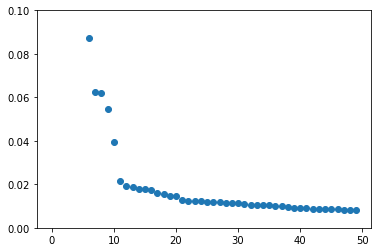

In [24]:

temp = pca.components_
temp1 = list(reversed(sorted(np.abs(temp[0,:]))))
plt.scatter(x=range(50),y=temp1[:50])
plt.ylim(0,0.1)

In [25]:
pca1 = temp[0,:]
mask = np.abs(pca1) > 0.02
#test[mask]['tokens']
len(mask)

3689

In [26]:
df = test.copy()
df['PCA_X'] = X_r[:,0]
df['PCA_Y'] = X_r[:,1]
df

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,PCA_X,PCA_Y
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-0.025258,-0.060600
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-0.025417,-0.061307
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-0.025035,-0.059599
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-0.024736,-0.058281
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-0.024736,-0.058281
...,...,...,...,...,...,...,...,...,...,...,...
5505,1214297,6,97.00.14,97.00.1,Services of households as employers of domesti...,Services households employers domestic personn...,97,T,10,-0.057781,0.035078
5506,1214298,6,97.00.19,97.00.1,Other services of households as employers of d...,Other services households employers domestic p...,97,T,10,-0.065867,0.004242
5511,1214303,6,98.10.10,98.10.1,Undifferentiated goods produced by private hou...,Undifferentiated goods produced private househ...,98,T,10,-0.027465,-0.044471
5515,1214307,6,98.20.10,98.20.1,Undifferentiated services produced by private ...,Undifferentiated services produced private hou...,98,T,10,-0.048521,-0.003183


<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

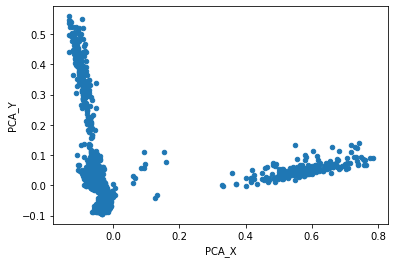

In [27]:
df.plot(x='PCA_X', y='PCA_Y', kind='scatter')

<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

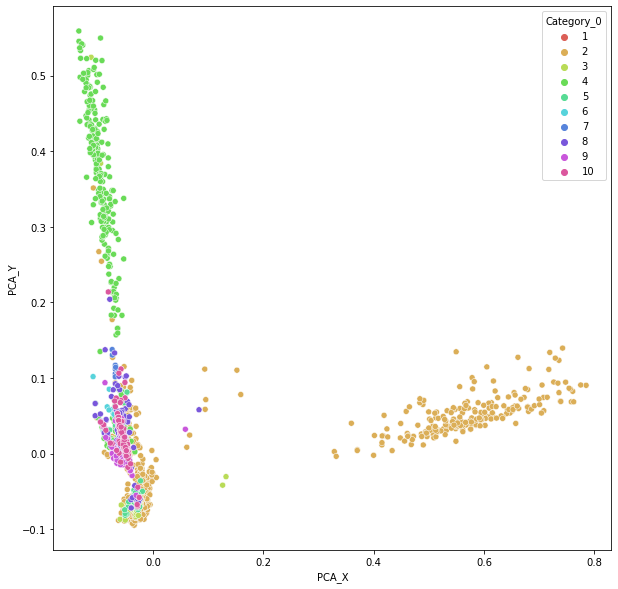

In [30]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='PCA_X', y='PCA_Y', hue='Category_0', palette=my_palette)

In [20]:
X = tfidf_pipeline.transform(test.tokens).todense()
y = test.Category_1
#target_names = ''

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

In [31]:
df2 = test.copy()
df2['PCA_X'] = X_r[:,0]
df2['PCA_Y'] = X_r[:,1]
df2

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,PCA_X,PCA_Y
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-0.025258,-0.060600
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-0.025417,-0.061307
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-0.025035,-0.059599
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-0.024736,-0.058281
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-0.024736,-0.058281
...,...,...,...,...,...,...,...,...,...,...,...
5505,1214297,6,97.00.14,97.00.1,Services of households as employers of domesti...,Services households employers domestic personn...,97,T,10,-0.057781,0.035078
5506,1214298,6,97.00.19,97.00.1,Other services of households as employers of d...,Other services households employers domestic p...,97,T,10,-0.065867,0.004242
5511,1214303,6,98.10.10,98.10.1,Undifferentiated goods produced by private hou...,Undifferentiated goods produced private househ...,98,T,10,-0.027465,-0.044471
5515,1214307,6,98.20.10,98.20.1,Undifferentiated services produced by private ...,Undifferentiated services produced private hou...,98,T,10,-0.048521,-0.003183


<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

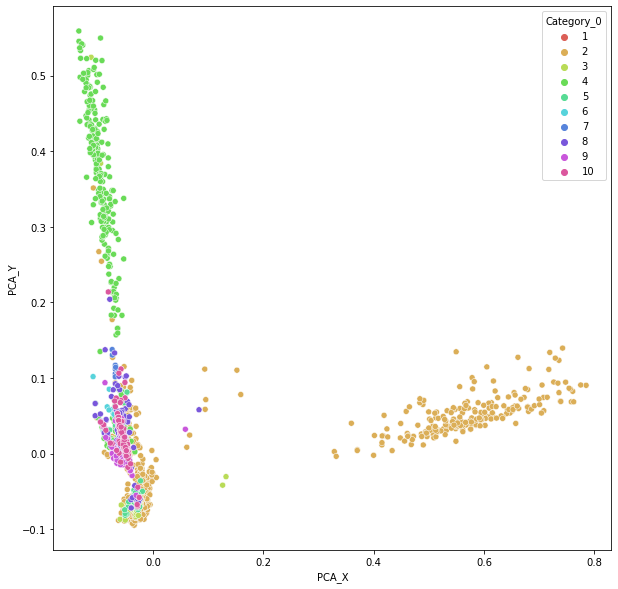

In [32]:

plt.figure(figsize=(10,10))
sns.scatterplot(data=df2, x='PCA_X', y='PCA_Y', hue='Category_0', palette=my_palette) #, legend=None)

<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

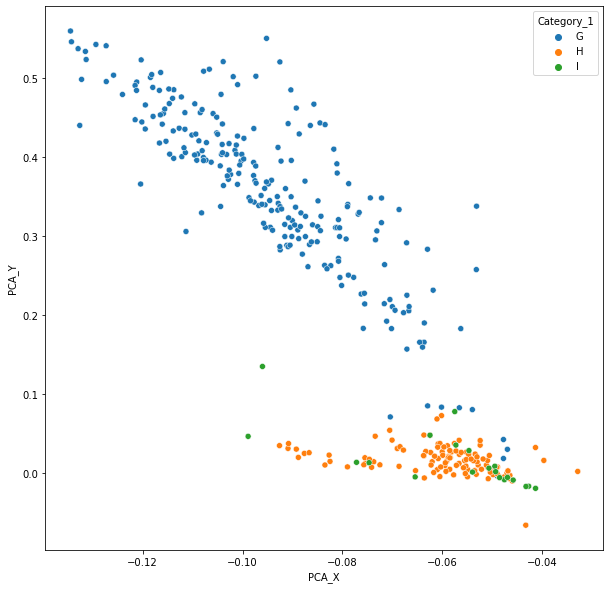

In [33]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df2[df2.Category_0==4],x='PCA_X', y='PCA_Y', hue='Category_1') #, legend=None)

<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

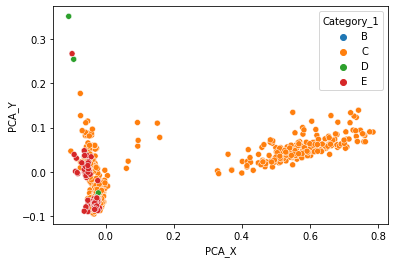

In [34]:
sns.scatterplot(data=df2[df2.Category_0==2],x='PCA_X', y='PCA_Y', hue='Category_1') #, legend=None)

<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

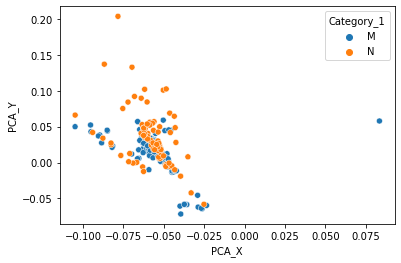

In [35]:
sns.scatterplot(data=df2[df2.Category_0==8],x='PCA_X', y='PCA_Y', hue='Category_1') #, legend=None)

<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

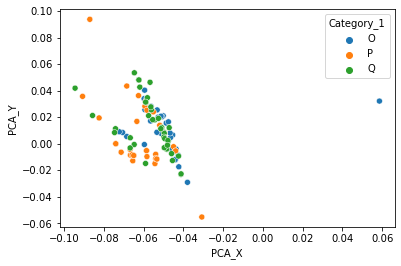

In [36]:
sns.scatterplot(data=df2[df2.Category_0==9],x='PCA_X', y='PCA_Y', hue='Category_1') #, legend=None)

<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

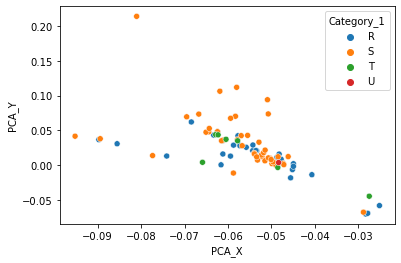

In [37]:
sns.scatterplot(data=df2[df2.Category_0==10],x='PCA_X', y='PCA_Y', hue='Category_1') #, legend=None)

# T-SNE visualisation

Adapted from: https://www.kaggle.com/premvardhan/amazon-fine-food-review-tsne-visualization

Not so good above 4 dimensions

In [38]:
from sklearn.manifold import TSNE
import pandas as pd

pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000, verbose=10)

tsne_data = model.fit_transform(X_r)

tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2"))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3218 samples in 0.006s...
[t-SNE] Computed neighbors for 3218 samples in 0.329s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3218
[t-SNE] Computed conditional probabilities for sample 2000 / 3218
[t-SNE] Computed conditional probabilities for sample 3000 / 3218
[t-SNE] Computed conditional probabilities for sample 3218 / 3218
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.432s
[t-SNE] Iteration 50: error = 70.8941345, gradient norm = 0.0659051 (50 iterations in 1.150s)
[t-SNE] Iteration 100: error = 62.7262383, gradient norm = 0.0096524 (50 iterations in 0.930s)
[t-SNE] Iteration 150: error = 61.6683044, gradient norm = 0.0061660 (50 iterations in 0.858s)
[t-SNE] Iteration 200: error = 61.2876701, gradient norm = 0.0045307 (50 iterations in 0.917s)
[t-SNE] Iteration 250: error = 61.1003036, gradient norm = 0.0020070 (50 iterations in 0.922s)
[t-SNE] KL divergence after 250 iterat

<AxesSubplot:xlabel='dim1', ylabel='dim2'>

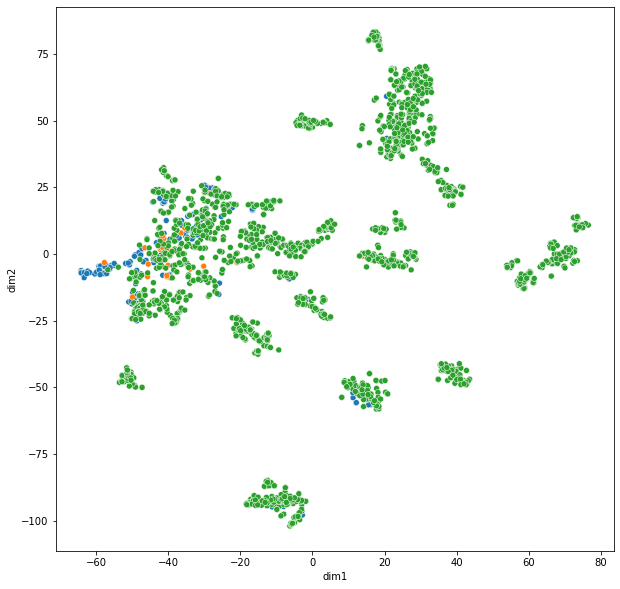

In [40]:
tsne_df["category"] = df2.Category_1
plt.figure(figsize=(10,10))
sns.scatterplot(data=tsne_df,x='dim1', y='dim2', hue='category', legend=None)

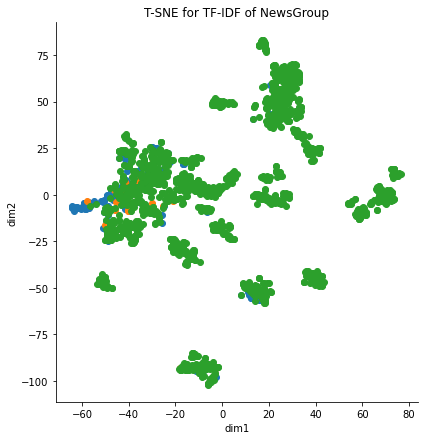

In [44]:
#sns.FacetGrid(tsne_df, hue="category", size=6, legend=None).map(plt.scatter, 'dim1', 'dim2').add_legend()
sns.FacetGrid(tsne_df, hue="category", height=6).map(plt.scatter, 'dim1', 'dim2')
plt.title("T-SNE for TF-IDF of NewsGroup");

### TODO: UMAP

In [45]:
import sklearn.metrics.pairwise

In [46]:
distance_matrix = sklearn.metrics.pairwise.cosine_distances(X)

<Figure size 432x288 with 0 Axes>

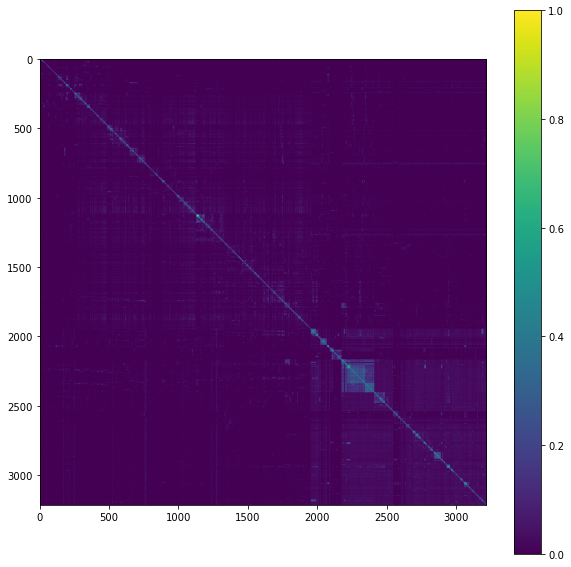

In [47]:
plt.set_cmap("viridis")
plt.figure(figsize=(10, 10))
plt.imshow(1-distance_matrix)
plt.colorbar();

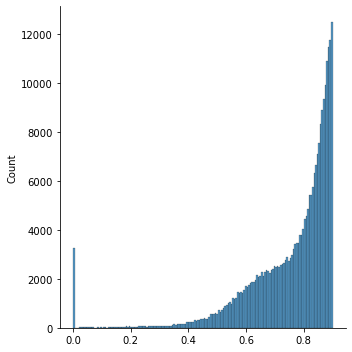

In [48]:
test = distance_matrix.flatten()
sns.displot(test[test<0.9])

<Figure size 720x720 with 0 Axes>

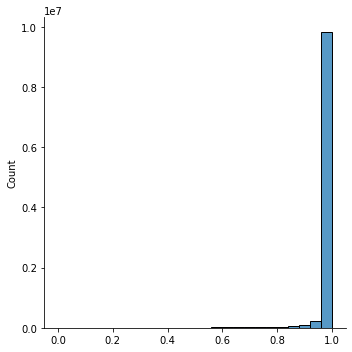

In [49]:
plt.figure(figsize=(10, 10))
sns.displot(distance_matrix.flatten())

## Discussion points:
* Curse of dimensionality
* Uni-modal pairwise distance distribution
* Dimensionality reduction
* Clustering e.g. HDBSCAN

## UMAP example

In [50]:
# u-map
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [51]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [52]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(test.tokens)

AttributeError: 'numpy.ndarray' object has no attribute 'tokens'